# Practical Session 3: Ensemble Learning Techniques

**Questions answered by Sumaiyah - sk940**

*Notebook by Ekaterina Kochmar*

This practical will address the use of ensemble-based learning techniques. You will be working with the otherwise familiar settings of classification and regression tasks. In this practical, you will use the familiar datasets and will also learn how to generate artificial datasets.

## Learning objectives

In this practical you will learn about:
- simple voting classifiers using hard and soft voting strategies
- bagging and pasting ensembles
- boosting and early stopping
- popular ensemble-based learning algorithms including `RandomForests` and `AdaBoost`

In addition, you will get more practice with `sklearn's` machine learning routines, and you will learn how to implement ensembles both from scratch and using `sklearn's` implementation.

**Bibliography**: Aurelien Geron, *Hands-On Machine Learning with Scikit-Learn and TensorFlow*.

## Setup

First of all, let's import a few common modules, ensure `matplotlib` plots are inline and define the parameters for the figures. Feel free to add your own settings for the notebook here:

In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Simple voting classifiers: hard and soft voting strategies

[The wisdom of the crowd](https://en.wikipedia.org/wiki/Wisdom_of_the_crowd) is the collective opinion of a group of individuals rather than that of a single expert. It has been shown that if you ask a complex question to thousands of random people and then aggregate their answers, in many cases you are likely to get an answer that is more accurate than an expert's prediction. This effect is nowadays widely used in practice and can be said to provide the basis for crowdsourcing approaches.

By analogy, if you combine decisions of multiple diverse classifiers, the resulting vote will often be better than a vote of any single predictor. Such combination of classifiers is called _ensemble_. Perhaps somewhat counterintuitively, the aggregated vote of an ensemble often achieves a higher accuracy than the best classifier in the ensemble. This works even if each predictor in the ensemble is a _weak learner_ (meaning that it works only slightly better than random guessing). The ensemble can still be a _strong learner_ achieving high accuracy, provided that there are:
- a sufficient number of weak learners, and
- their decisions are sufficiently diverse.

How is this possible? Here is a statistical analogy: suppose you have a slightly biased coin that has a $51\%$ chance of coming up heads and a $49\%$ chance of coming up tails. If you toss it $1000$ times, you will get around $510$ heads and $490$ tails, and hence a majority of heads. If you do the math or run simulations, you will find out that the probability of obtaining the majority of heads after $1000$ tosses of this coin approaches $73\%$. After $10K$ tosses, the probability of having a majority of heads is about $97\%$. This is explained by the [_law of large numbers_](https://en.wikipedia.org/wiki/Law_of_large_numbers): over a large number of tosses the ratio of heads gets closer to the probability of heads ($51\%$).

In [2]:
import scipy, math
import scipy.special

def probability(p, n, x):
    binom = scipy.special.comb(n, x, exact=True) * math.pow(p, x) * math.pow((1-p), n-x)
    return binom

prob_maj = 0.0
for x in range(501, 1001):
    prob_maj += probability(0.51, 1000, x)
    
print(prob_maj)

0.7260985557305037


The code below simulates $10$ independent series of coin tosses, and then plots the results. You can see in the figure below that as the number of tosses increases, all $10$ series end up close to $51\%$ and thus are consistently above $50\%$.

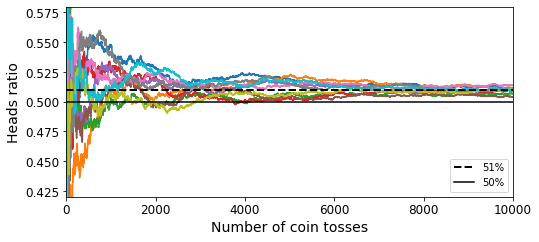

In [3]:
np.random.seed(42)
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

Similarly, if you combine $1000$ classifiers, each of which is individually correct only $51\%$ of the time, and then predict the majority voted class, you can get up to $73\%$ accuracy.

For this to work, the classifiers need to be independent and sufficiently diverse, i.e. they need to make independent, uncorrelated errors. In practice, this is hard to achieve because the classifiers are usually all trained on the same data.

Let's apply voting strategy to some data: this time, we'll be working with a synthetic (i.e., artificially generated) [`moons` dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html), that includes two interleaving half circles and provides a good 'toy' example for testing out classification strategies.

Let's first generate the data points and visualise them on a plot:

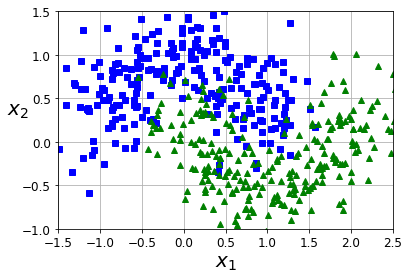

In [4]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

Next, let's split the dataset into training and test sets and train some classifiers on the training data:

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

The code below shows how to apply several classifiers to this data, with a couple of classifiers that we haven't used before in this course: [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and [`Support Vector Machines`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) (`SVC`) classifier. For the moment, don't worry about the particular details of the classifiers' implementation (if you are interested in learning more about them, check out `sklearn's` documentation; we'll discuss `RandomForestClassifier` in this practical; `Support Vector Machines` is covered in detail in the Part II [Machine Learning and Bayesian Inference](https://www.cl.cam.ac.uk/teaching/2021/MLBayInfer/) course). The point here is that we are combining *diverse* classifiers in an ensemble: in essence, `RandomForestClassifier` runs recursive partitioning on the data, while `Support Vector Machines` try to construct a linear boundary between the classes (as discussed in Lecture 3). Feel free to experiment with your own selection of classifiers from the [`sklearn's`](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) suite.

In [9]:
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42, solver='warn',
                                                 tol=0.0001, verbose=0,
                                                 warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                             

Let's look into how correlated the predictions of the classifiers are: first, get the predictions on the test data, next store them as a `pandas` DataFrame, and finally apply `.corr()` function:

In [10]:
import pandas as pd

def get_predictions(clf):
    clf.fit(X_train, y_train)
    return clf.predict(X_test)


preds = {'lr': get_predictions(log_clf), 
        'rf': get_predictions(rnd_clf), 
        'svc': get_predictions(svm_clf)}
df = pd.DataFrame(data=preds)
df[:100]

c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


,lr,rf,svc
0,1,0,0
1,0,0,0
2,0,0,0
3,1,1,1
4,1,1,1
...,...,...,...
95,1,1,1
96,0,0,0
97,1,0,1
98,0,0,0


In [11]:
df.corr()

,lr,rf,svc
lr,1.000000,0.661141,0.824080
rf,0.661141,1.000000,0.802424
svc,0.824080,0.802424,1.000000


Will this correlation in the individual classifiers' predictions be sufficient for an ensemble? Let's check this out by combining the votes with a *hard voting strategy*: the ensemble classifier will simply choose the majority class predicted by the three classifiers.

The code below prints out individual classifiers' accuracy scores along with the ensemble's accuracy score:

In [12]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in versi

As you can see, the voting classifier slightly outperforms each of the three individual classifiers, including the most accurate one(s). In addition, if individual classifiers can estimate class probabilities (i.e., if they have `predict_proba()` method), you can use _soft voting_ strategy, that is, estimate highest class probability averaged over individual classifiers. In comparison to the hard voting strategy, soft voting gives more weight to highly confident votes.

`SVC` classifier doesn't estimate class probabilities by default, so you need to set the `probability` hyperparameter to `True`.

In [13]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42, solver='warn',
                                                 tol=0.0001, verbose=0,
                                                 warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                             

Not let's estimate the accuracy of the voting classifier in this mode:

In [14]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed t

## Bagging ensembles: bagging and pasting

One way to ensure that the classifiers are sufficiently diverse in their predicitons is to select different training algorithms. As we said before, often it is hard to ensure that the classifiers' errors are not highly correlated because the classifiers are ultimately trained on the same data.

So, another way to make sure you end up with diverse classifiers is to train them on different random subsets of the training set. There are two ways to do that:
- sampling _with replacement_ is called [_bagging_](https://link.springer.com/article/10.1023/A:1018054314350) – short for _bootstrap aggregating_
- sampling _without replacement_ is called [_pasting_](https://link.springer.com/article/10.1023/A:1007563306331)

Both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor.

When applied to a new, test instance the ensemble classifier aggregates the predictions of all predictors and estimates the statistical mode (i.e., most frequent prediction).

**Question**: Is this similar to the hard or the soft voting strategy? 

Let's use `sklearn's BaggingClassifier` to train an ensemble of $500$ [`Decision Trees`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), each trained on $100$ training instances randomly selected from the training set with replacement (for bagging, but you can change the strategy to pasting by setting `bootstrap` to `False`). In addition, both bagging and pasting strategies are good for parallelisation: predictors can all be trained in parallel on different CPU cores or even different servers. Setting `n_jobs` parameter to $-1$ tells `sklearn` to use all available CPU cores:

In [15]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

#use bootstrap=False for pasting
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
#n_jobs = use all of the available CPU cores
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

**Question**: [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) automatically performs soft voting when the base classifier can estimate class probabilities (i.e., has a `predict_proba()` method). Which strategy – hard or soft voting – does `BaggingClassifier` follow with the `DecisionTreeClassifier` as the base classifier?

Let's calculate the accuracy score for the bagging classifier that combines $500$ Decision Tree estimators with a prediction of a single Decision Tree trained on the same data:

In [16]:
print(accuracy_score(y_test, y_pred))

0.904


In [17]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


To get more insight into the results, let's also plot the decision boundary for the two classifiers:

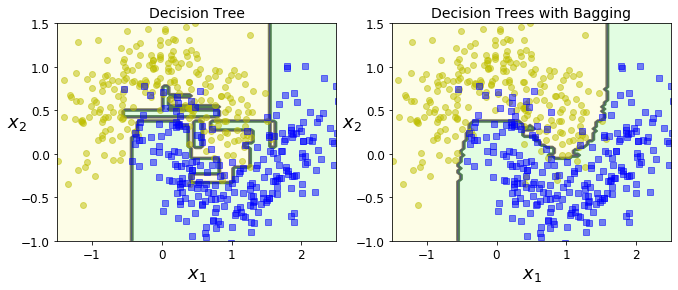

In [18]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

Even though the ensemble makes a comparable number of errors on the training set as a single Decision Tree, its decision boundary is less irregular. This suggests that ensemble's predictions will likely generalise better than the single `Decision Tree`'s predictions
when applied to the new data.

### Out-of-Bag evaluation

With bagging, some of the instances get sampled several times for any given predictor, while others may never be selected at all. By default, `BaggingClassifier` samples $m$ training instances with replacement, where $m$ is the size of the training set. As $m$ grows, the ratio of the training instances that are sampled on average for each predictor approaches $1 - exp(-1)$, i.e. around $63\%$. The remaining $37\%$ of the training instances that are never used by the predictors are called *out-of-bag* (*oob*) instances.

Mathematical proof of the above: With $m$ training instances in the set, the probability of not picking an instance in a random draw is $\frac{m-1}{m}$. For sampling with replacement, the probability of not picking an instance in $m$ random draws is $(\frac{m-1}{m})^m$. In the limit of a large number of $m$, this becomes:

\begin{equation}
\lim_{m\to\infty} (1 - \frac{1}{m})^m = e^{-1} = 0.368 \approx 37\%
\end{equation}

Since a predictor never sees these instances during training, they can be used for evaluation without the need for an additional validation set or cross-validation experiments. You can evaluate the ensemble itself by averaging each predictor's performance on the oob instances.

The code below shows you how to do that: if you set `oob_score` to `True`, the bagging classifier will be evaluated on the oob instances after training, and you can output the score as `oob_score_`.

In [19]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

This means that the bagging classifier is likely to achieve around $90\%$ accuracy on the test data, too. Let's check the results:

In [20]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

Close enough! You can also take a look into the decision process by printing out the predictions of the classifier on the training instances. Since the base estimator has a `predict_proba()` method, what you see here are the class probabilities assigned by the classifier to negative and positive classes for each instance:

In [62]:
# bag_clf.oob_decision_function_

## Random Forests

[`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) is an ensemble of Decision Trees typically trained via the bagging method. The number of training instances (`max_samples`) is usually set to the total size of the training set. So, in fact, `RandomForestClassifier` will be roughly equivalent to the `BaggingClassifier` that takes Decision Trees as base estimators with the following parameters:

In [22]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

The key difference is that, rather than using `BaggingClassifier` and passing it a `DecisionTreeClassifier`, you can rely on the `sklearn's RandomForestClassifier` implementation, which is more convenient and optimised for Decision Trees:

In [23]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, 
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

Let's estimate the difference between the two classifiers' predictions:

In [24]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # see to what extent predictions are identical

0.976

I.e., the two classifiers are almost identical in their predictions. The Random Forest algorithm introduces extra randomness when growing trees: instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. As a result, the model is more diverse and in general yields better results.

Let's visualise the decision boundary for a random set of $15$ Decision Trees to get a better idea of where the diversity comes from:

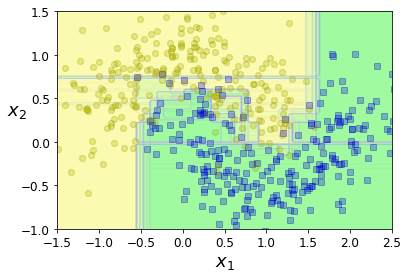

In [25]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], 
                           alpha=0.02, contour=False)

plt.show()

**Extra material**: One further way to introduce randomness into the training process is to not only select a random subset of features when splitting a node, but also use a random threshold for each feature rather than searching for the best possible thresholds as traditional Decision Trees do. Since estimating best possible threshold for each feature at every node is also one of the most time-consuming tasks, this modification to the algorithm makes it more efficient. The algorithm that exploits this idea is called *Extremely Randomised Trees ensemble*, or *Extra-Trees*, and you can use it via [`sklearn's ExtraTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.ExtraTreeClassifier.html) implementation.

### Feature importance

Another useful property of the Random Forests classifier is that it can help you measure the relative importance of each feature by looking at how much the tree nodes that use this particular feature reduce impurity of the nodes on average (i.e., across all trees in the forest). The results are scaled so that the sum of all feature importances is equal to $1$.

Because features used in the *iris* and *digits* datasets are highly interpretable, let's estimate feature importances on these two datasets: 

In [26]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [27]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

**Question**: What do these results suggest? Are they similar to your observations from the previous experiments on this dataset? 

*Digits* dataset provides further interpretability of the results if we plot them. What does the figure below suggest?

In [28]:
from sklearn import datasets
digits = datasets.load_digits()

rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(digits["data"], digits["target"])

c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

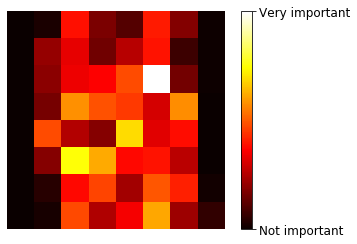

In [29]:
def plot_digit(data):
    image = data.reshape(8, 8)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")
    
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

## AdaBoost

*Boosting*, or *hypothesis boosting* is an ensemble method that can combine several weak learners into a strong learner. The general idea is to train predictors sequentially in such a way that each next predictor tries to correct its predecessor. The most popular among boosting methods are *AdaBoost* (which stands for *Adaptive Boosting*) and *Gradient Boosting*. Let's apply *AdaBoost* first.

The idea behind *AdaBoost* is as follows: in order to correct the predecessor's mistakes, the algorithm assigns higher weights to the training instances that the predecessor underfitted. I.e., the next step pays more attention to such instances and the algorithm focuses more on the hard cases.

Here is the step-by-step strategy:
- start with the first classifier (i.e., this can be a Decision Trees classifier)
- train it and use it to make predictions on the training set
- increase the relative weight of misclassified training instances
- train a second classifier with these new updated weights and make new predictions
- update weights using the new predictions
- continue until stopping criteria are satisfied.

For instance, suppose each instance's original weight $w^{(i)}$ is set to $\frac{1}{m}$, where $m$ is the number of instances. The first classifier is applied, and its error rate $r_1$ is computed on the training set using the equation below:

\begin{equation}
r_j = \frac{\sum_{\hat{y}^{(i)}_j \neq y^{(i)}} w^{(i)}}{\sum_{i=1}^m w^{(i)}}
\end{equation}

where $\hat{y}^{(i)}_j$ is the prediction of the $j$-th classifier on the $i$-th instance. The predictor's weight $\alpha_j$ is then estimated using:

\begin{equation}
\alpha_j = \eta log \frac{1-r_j}{r_j}
\end{equation}

where $\eta$ is the learning rate, a hyperparameter that defaults to $1$. The more accurate the predictor is, the higher its weight will be; if a predictor is guessing randomly, its weight will be close to $0$; and if it performs worse than random guessing it will get a high negative weight.

Next, the weights are updated and the misclassified instances are boosted as follows:

\begin{equation}
  w^{(i)}=\begin{cases}
    w^{(i)}, & \text{if $\hat y_j^{(i)} = y_j^{(i)}$}\\
    w^{(i)} exp(\alpha_j), & \text{if $\hat y_j^{(i)} \neq y_j^{(i)}$}
  \end{cases}
\end{equation}

Then all the instances weights are normalised (i.e., divided by $\sum_{i=1}^m w^{(i)}$). The new predictor is trained on the updated training instances, applied to the training set, its weight is computed, weights are updated again, and so on. The algorithm stops when either the predefined number of predictors is reached or a perfect predictor is found.

(This process should remind you about other sequential learning techniques we've discussed, e.g. Gradient Descent. The difference is, instead of tweaking a single predictor's parameters to minimise a cost function, AdaBoost adds predictors to the ensemble gradually making the prediction better.)

**Question**: We said earlier than one of the advantages of bagging and pasting strategies is that predictors can all be trained in parallel. Is the same applicable to AdaBoost? 

At prediction time, AdaBoost computes the predictions of all the predictors and weighs them according to $\alpha_j$. The predicted class is then the one that receives the majority of weighted votes, i.e.:

\begin{equation}
 \hat y(x) = argmax_{k} \sum_{j=1; \hat y_j(x)=k} ^{N} \alpha_j
\end{equation}

with $N$ being the number of predictors.

`sklearn's` implementation of AdaBoost uses *Stagewise Additive Modeling using a Multiclass Exponential loss function* (or *SAMME* for short) multiclass version of the algorithm, which in a binary case simply defaults to AdaBoost. In addition, if the base estimators can estimate class probabilities (have `predict_proba()` method), `sklearn's` algorithm relies on class probabilities rather than predictions, which generally performs better. This version is called *SAMME.R*, where *R* stands for "Real".

Let's train [`sklearn's AdaBoostClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), for example using $200$ *Decision Stumps* (trees composed of a single decision node and two leaf nodes, `max_depth=1`):

In [30]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

And let's plot the decision boundary of the algorithm:

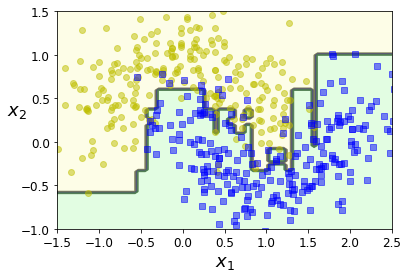

In [31]:
plot_decision_boundary(ada_clf, X, y)

To get a bit more insight into how the decision boundaries change from one step to another and with a different learning rate, let's plot decision boundaries for $5$ consecutive predictors, in this case using `SVC` as the estimator. Note how the first classifiers usually get many instances wrong, while the following predictors are gradually getting better. The plot on the right presents the very same $5$ consecutive classifiers, but assigns half the learning rate (i.e., the misclassified instances weights are only boosted half as much at every iteration):

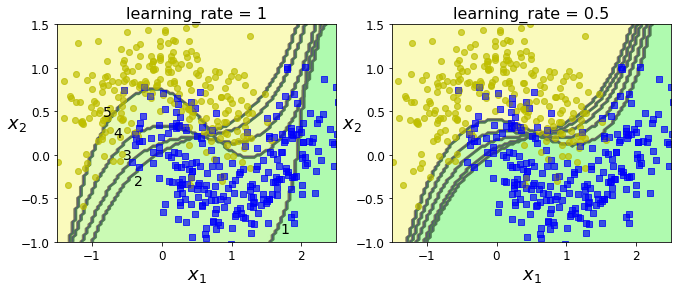

In [32]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(1.70,  -0.90, "1", fontsize=14)
        plt.text(-0.40, -0.35, "2", fontsize=14)
        plt.text(-0.55, -0.05, "3", fontsize=14)
        plt.text(-0.70,  0.20, "4", fontsize=14)
        plt.text(-0.85,  0.45, "5", fontsize=14)

plt.show()

In addition, here is the full list of parameters and attributes of the algorithm:

In [33]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']

E.g., you can check classification errors for each estimator in the boosted ensemble as follows:

In [34]:
ada_clf.estimator_errors_

array([0.18133333, 0.27512937, 0.28334096, 0.35488317, 0.3171361 ,
       0.38272512, 0.35630662, 0.33148186, 0.40484099, 0.29959284,
       0.38482533, 0.37793452, 0.4396849 , 0.41956551, 0.41977426,
       0.42276892, 0.44540522, 0.4592429 , 0.43517238, 0.4795022 ,
       0.46538072, 0.48000343, 0.43464541, 0.44653579, 0.47534577,
       0.48382716, 0.45804523, 0.46674707, 0.4374261 , 0.48598125,
       0.48769271, 0.4722106 , 0.46346519, 0.46165373, 0.44202223,
       0.44509139, 0.47099366, 0.45066309, 0.4881181 , 0.47269775,
       0.47884803, 0.46937918, 0.4663008 , 0.44912872, 0.45639441,
       0.46252216, 0.48048523, 0.49000957, 0.4780251 , 0.45748808,
       0.47390931, 0.4836773 , 0.45432253, 0.4816146 , 0.49129336,
       0.48627751, 0.48533895, 0.48977843, 0.4781294 , 0.45990675,
       0.45628973, 0.45333756, 0.48145777, 0.47828933, 0.46468214,
       0.46348201, 0.47643265, 0.471952  , 0.45673327, 0.47977324,
       0.46875606, 0.46464402, 0.45684007, 0.46146966, 0.46037

## Gradient Boosting

Gradient Boosting is another popular boosting algorithm. It also works sequentially adding new predictors to the ensemble, each one correcting the errors from its predecessor. Unlike AdaBoost, it's trying to fit each new predictor to the *residual errors* made by the previous predictor. 

Let's this time apply the boosting algorithm to a regression task. First, generate a synthetic noisy quadratic training set:

In [35]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

Next, let's fit a single [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html):

In [36]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

Now train a second `DecisionTreeRegressor` on the residual errors made by the first predictor:

In [37]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

Finally, let's train a third regressor on the residual errors made by the second predictor:

In [38]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

That's it – you've just built an ensemble containing three trees. It can now be applied to new instances by making predictions based on adding up the predictions from all three trees:

In [39]:
X_new = np.array([[0.8]])

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

y_pred

array([0.75026781])

Let's visualise the results by plotting the predictions from each tree on the left and the ensemble on the right. E.g., in the first row the ensemble contains only one tree, so its predictions are exactly the same as the first tree's predictions. In the second row, the second tree is trained on the residual errors from the first tree, and the ensemble's prediction is based on the sum of the predictions of the two trees. You can see how the predictions of the ensemble are gradually getting better:

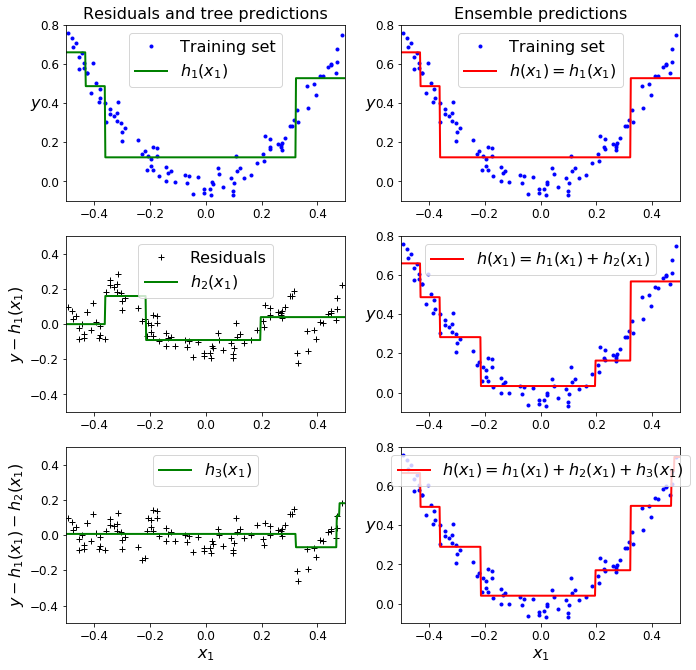

In [40]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], 
                 label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], 
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], 
                 label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], 
                 label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], 
                 label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], 
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

A simpler way to train ensembles of *Gradient Boosted Regression Trees* is to use [`sklearn's GradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) implementation. In addition to the typical hyperparameters that control the growth of the trees, it also includes hyperparameters that control the ensemble training, e.g. `n_estimators`:

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

**Question**: Another hyperparameter is `learning_rate`. What is it responsible for and what effect on the resulting ensemble does it have? 

Feel free to check `sklearn's` documentation, as well as look into the comparison of two ensembles: the one with a lower number of estimators and a higher learning rate, and a 'slow learner' with a lower learning rate but a higher number of estimators:

In [42]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

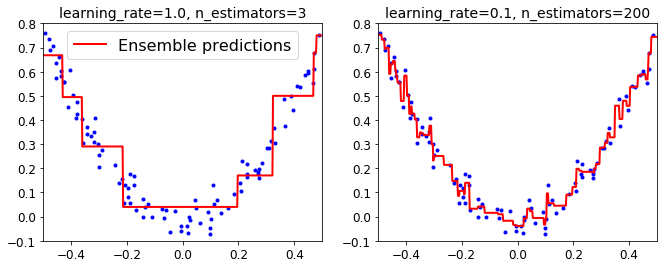

In [43]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

**Question**: What generalisation behaviour can you expect from each of these ensembles? 

### Gradient Boosting with Early Stopping

The examples above demonstrate ensembles with a different number of estimators. Which one is better? How can you quantitatively estimate the optimal number of predictors?

One technique that you can use is called *early stopping* – it allows your algorithm to stop as soon as the validation error reaches a minimum. An easy way to implement this with `sklearn` is to use `staged_predict()` method as the code below demonstrates:

In [44]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=100)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=68,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Let's visualise the validaton errors and the optimal number of estimators:

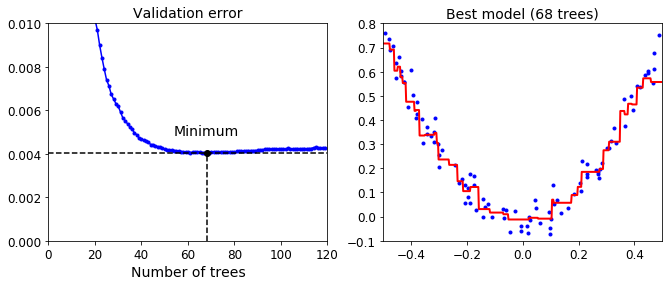

In [45]:
min_error = np.min(errors)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

plt.show()

Finally, an alternative to training a large number of estimators and then looking back in order to find the optimal number of those is to allow the algorithm to stop training when the validation error does not improve over a number of consecutive iterations (e.g., $5$ in the code below). For that to work, set the `warm_start` to `True`:

In [46]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

print(gbrt.n_estimators)

74


# Your tasks

1. Run the code in the notebook. During the practical session, be prepared to discuss the methods and answer the questions from this notebook:

    * When applied to a new, test instance bagging classifier aggregates the predictions of all predictors and estimates the statistical mode. Is this similar to the hard or the soft voting strategy? **Hard voting strategy. If it is simply picking the most frequent prediction it is not taking into account/weighting any value of confidence for each predictors output. It is simply using a majority voting strategy, similar to hard voting**
    * [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) automatically performs soft voting when the base classifier can estimate class probabilities (i.e., has a `predict_proba()` method). Which strategy – hard or soft voting – does `BaggingClassifier` follow with the `DecisionTreeClassifier` as the base classifier? **From the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) we can see that `DecisionTreeClassifier` has a `predict_proba(X[, check_input])` that can predict class probabilities of the input samples X. As such the `BaggingClassifier` would use a soft voting strategy.**
    * What do the feature importance weights obtained on the *iris* dataset suggest? Are they similar to your observations from the previous experiments on this dataset? **The results for the iris dataset suggest that petal length and width are the most important features that determine its classification. It also suggest that sepal width has very litte correlation with classification. The data from the digits dataset suggests that, to classify a digit, you only really need to look at the pixels in the middle of the frame. This very much makes sense as the digits were all drawn on a white background and to decifer a digit, you need to look at the pattern of black pixels in the frame.**
    * We said earlier than one of the advantages of bagging and pasting strategies is that predictors can all be trained in parallel. Is the same applicable to AdaBoost? **I do not belive so. The AdaBoost is a sequential process, you can only decide how to adapt the weights in an iteration based off of results in the previous iterations.**
    * One of the hyperparameters of the boosting algorithms is learning_rate. What is it responsible for and what effect on the resulting ensemble does it have? **The `learning_rate` hyperparameter is responsible for slowing down the learning in the gradient boosting model. It controls the weighting of new trees added to the model. The lower the learning rate, the more trees you'll need to actually capture the data well**
    * What generalisation behaviour can you expect from each of the tree regressor ensembles (using different learning rates and different number of estimators – see above)? **The predictor on the left has got the general pattern of the data without being tuned to each specific example in the traning data. The predictor on the right captures the data much better but also appears to overfit the data. I think too many estimators have been added and the predictor has acquired the peculiarites present in the training data. I don't think it will generalise well.** 

2. Apply ensemble techniques of your choice to one of the datasets you've worked on during the previous practicals and report your findings.

3. **Optional**: If you want more practice with these techniques, try implementing a [*stacking algorithm*](https://en.wikipedia.org/wiki/Ensemble_learning#Stacking). There is no available implementation of this approach in `sklearn` so it needs to be implemented from scratch. The idea is as follows:
    * Split a dataset of your choice into three subsets – training, validation and test.
    * Train a number of predictors on the training data and apply them to the validation data.
    * Treat the predictions of those predictors on the validation data to generate new training set: you can use the predictions of the estimators as new features (i.e., each training instance will have as many features as the number of predictors you originally used), and the validation data targets as the new training instances targets. 
    * Now train a *blender* – a classifier of your choice – on the new training data created this way. Together with the original classifiers, the blender forms a stacking ensemble.
    * Finally, apply your original classifiers to the test set, feed their predictions to the blender, and use blender's output as the prediction on the test set.

**2. Applying ensemble techniques to the IRIS dataset**

In [47]:
# Load dataset
from sklearn.datasets import load_iris
iris = load_iris()

In [49]:
from sklearn.model_selection import StratifiedShuffleSplit

# Split data
X, y = iris["data"], iris["target"]

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
split.get_n_splits(X, y)
print(split)       

for train_index, test_index in split.split(X, y):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2,
            train_size=None)
TRAIN: 120 TEST: 30


**2a. Try hard voting strategy with 3 classifiers**

In [51]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9666666666666667
RandomForestClassifier 0.9666666666666667
SVC 0.9666666666666667
VotingClassifier 1.0


c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled fe

In [52]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9666666666666667
RandomForestClassifier 0.9666666666666667
SVC 0.9666666666666667
VotingClassifier 0.9666666666666667


c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\sumaiyah\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled fe

It seems that the original performance of each classifier is quite high (0.9666666666666667). Surprisingly in this case the hard voting strategy out performs the soft voting strategy. The converse was the case earlier in the notebook on the moons dataset

**2b. Random Forest**

In [58]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, 
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [59]:
y_pred_rf

array([0, 2, 1, 1, 0, 1, 0, 0, 2, 1, 2, 2, 2, 1, 0, 0, 0, 1, 1, 2, 0, 2,
       1, 1, 2, 2, 1, 0, 2, 0])

sum(y_pred_rf == y_test) / len(y_test)

**2c. Bagging ensembles: bagging vs pasting vs just DT**

In [64]:
# Bagging
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)

# Pasting
paste_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=False, n_jobs=-1, random_state=42)
paste_clf.fit(X_train, y_train)
y_pred_pas = paste_clf.predict(X_test)

# Just Decision Tree
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

print("Bagging acc: ", accuracy_score(y_test, y_pred_bag))
print("Pasting acc: ", accuracy_score(y_test, y_pred_pas))
print("Just tree acc: ", accuracy_score(y_test, y_pred_tree))

Bagging acc:  0.9666666666666667
Pasting acc:  0.9666666666666667
Just tree acc:  0.9333333333333333


For the iris dataset, the performance of the bagging and pasting ensembles outperforms the simple decision tree classifier. There is little performance difference between the bagging and pasting classifiers 